# Exploratory Notebook — Weather, Holidays, and Events

This notebook explores how **external factors** affect Citi Bike demand and sets up context for later user segmentation and station typology.

We focus on three types of external signals:

- **Weather** (temperature, rain, wind, clouds)  
- **US holidays** (reduced commuting, more leisure)  
- **NBA home games in New York** (evening event-driven peaks)

---

## What we do here

- Load and clean Citi Bike trip data in a memory-safe way  
- Aggregate trips to **hourly demand**  
- Join **hourly weather** and train a simple **Random Forest** to see how much demand can be explained by weather + calendar  
- Quantify and visualize **demand differences** between:
  - normal days vs **rainy / snowy / windy / cloudy** conditions  
  - **holidays vs non-holidays**  
  - **NBA home game evenings vs neighbouring days**  

These results feed into the **business discussion** of when demand is hardest to meet and which user groups are most affected.

---

## How to run

1. Run the **load & preview** section first (trips and weather).  
2. Then run the sections in order:
   - hourly aggregation + weather merge  
   - weather model + weather EDA  
   - holidays  
   - NBA games  
3. Adjust file paths at the top of each code block if needed.

---

## Table of Contents

- Step 1 — Load and preview trips data  
- Step 2 — Aggregate trips to hourly demand  
- Step 3 — Load weather data and merge with demand  
- Step 4 — Weather-based demand model (Random Forest)  
- Step 5 — Weather effects: descriptive analysis  
- Step 6 — Add US holidays and analyze holiday vs non-holiday demand  
- Step 7 — Add NBA home games and analyze event-driven uplift


## Section 1 -- Weather, Holiday and Event based analysis of demand

### Step 1 — Load and preview trips data

**Purpose:** Load the raw Citi Bike trips file in chunks, apply the same cleaning logic as the prediction notebook, and briefly inspect the cleaned schema.

This step:

- standardizes timestamps and station coordinates  
- converts key columns to numeric / categorical dtypes  
- produces a small preview (`head()` + dtypes) of the cleaned chunk  

All later analyses (weather, holidays, events, segmentation) rely on the same cleaned representation of the trips.


### Step 2 — Aggregate trips to hourly demand

**Purpose:** Collapse individual trips into a single **hourly demand time series**.

This step:

- extracts the trip start time for each ride  
- floors timestamps to the nearest hour  
- counts trips per hour across all of 2018  
- produces a compact `hourly_trips` table with:
  - `hour` (datetime)  
  - `trips_total` (number of trips starting in that hour)

This hourly series is the backbone for all external-factor analyses (weather, holidays, NBA games).


In [8]:
from pathlib import Path
import pandas as pd
import numpy as np

trips_path = Path("../data/Trips_2018.csv")

iter_csv = pd.read_csv(
    trips_path,
    chunksize=100_000,
    low_memory=True,
    usecols=[
        "tripduration","starttime","stoptime",
        "start_station_id","start_station_latitude","start_station_longitude",
        "end_station_id","end_station_latitude","end_station_longitude",
        "bikeid","usertype","birth_year","gender","Unnamed: 0",
    ],
)

def clean_chunk(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=[c for c in ["Unnamed: 0"] if c in df.columns], errors="ignore")

    rename_map = {
        "starttime": "started_at",
        "stoptime": "ended_at",
        "start_station_id": "start_station_id",
        "end_station_id": "end_station_id",
        "start_station_latitude": "start_lat",
        "start_station_longitude": "start_lng",
        "end_station_latitude": "end_lat",
        "end_station_longitude": "end_lng",
    }
    df = df.rename(columns=rename_map)

    df["started_at"] = pd.to_datetime(df["started_at"], errors="coerce")
    df["ended_at"] = pd.to_datetime(df["ended_at"], errors="coerce")

    df["hour_start"] = df["started_at"].dt.floor("h")
    df["hour_end"] = df["ended_at"].dt.floor("h")

    for col in ["start_station_id","end_station_id","bikeid","birth_year","gender","tripduration"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "start_station_id" in df: df["start_station_id"] = df["start_station_id"].astype("Int32")
    if "end_station_id" in df: df["end_station_id"] = df["end_station_id"].astype("Int32")
    if "bikeid" in df: df["bikeid"] = df["bikeid"].astype("Int32")
    if "birth_year" in df: df["birth_year"] = df["birth_year"].astype("Int16")
    if "gender" in df: df["gender"] = df["gender"].astype("Int8")
    if "tripduration" in df: df["tripduration"] = df["tripduration"].astype("Int32")

    for c in ["start_lat","start_lng","end_lat","end_lng"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")

    if {"start_lat","start_lng","end_lat","end_lng"}.issubset(df.columns):
        bad = (
            (df["start_lat"].abs() > 90) | (df["end_lat"].abs() > 90) |
            (df["start_lng"].abs() > 180) | (df["end_lng"].abs() > 180)
        )
        df = df.loc[~bad]

    if "usertype" in df.columns:
        df["usertype"] = df["usertype"].astype("category")

    cols = [
        "hour_start","hour_end","started_at","ended_at",
        "start_station_id","start_lat","start_lng",
        "end_station_id","end_lat","end_lng",
        "tripduration","bikeid","usertype","birth_year","gender",
    ]
    cols = [c for c in cols if c in df.columns]
    return df[cols]

raw = next(iter_csv)
df_preview = clean_chunk(raw)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

print("rows in preview chunk:", len(df_preview))
print("cols:", df_preview.shape[1])
print("started_at range in preview:", df_preview["started_at"].min(), "→", df_preview["started_at"].max())

print("\ncolumn dtypes:")
print(df_preview.dtypes)

print("\nhead:")
display(df_preview.head(10))


rows in preview chunk: 100000
cols: 15
started_at range in preview: 2018-01-01 00:17:09.185000 → 2018-01-31 23:58:18.174000

column dtypes:
hour_start          datetime64[ns]
hour_end            datetime64[ns]
started_at          datetime64[ns]
ended_at            datetime64[ns]
start_station_id             Int32
start_lat                  float32
start_lng                  float32
end_station_id               Int32
end_lat                    float32
end_lng                    float32
tripduration                 Int32
bikeid                       Int32
usertype                  category
birth_year                   Int16
gender                        Int8
dtype: object

head:


,hour_start,hour_end,started_at,ended_at,start_station_id,start_lat,start_lng,end_station_id,end_lat,end_lng,tripduration,bikeid,usertype,birth_year,gender
0,2018-01-01 13:00:00,2018-01-01 14:00:00,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72,40.767273,-73.993927,505,40.749012,-73.988487,970,31956,Subscriber,1992,1
1,2018-01-01 15:00:00,2018-01-01 15:00:00,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72,40.767273,-73.993927,3255,40.750584,-73.994682,723,32536,Subscriber,1969,1
2,2018-01-01 15:00:00,2018-01-01 15:00:00,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72,40.767273,-73.993927,525,40.755943,-74.002113,496,16069,Subscriber,1956,1
3,2018-01-01 15:00:00,2018-01-01 15:00:00,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72,40.767273,-73.993927,447,40.763706,-73.985161,306,31781,Subscriber,1974,1
4,2018-01-01 18:00:00,2018-01-01 18:00:00,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72,40.767273,-73.993927,3356,40.774666,-73.984703,306,30319,Subscriber,1992,1
5,2018-01-01 21:00:00,2018-01-01 21:00:00,2018-01-01 21:31:54.192,2018-01-01 21:58:36.353,72,40.767273,-73.993927,482,40.739357,-73.999321,1602,30106,Subscriber,1968,1
6,2018-01-02 07:00:00,2018-01-02 08:00:00,2018-01-02 07:54:53.646,2018-01-02 08:06:55.872,72,40.767273,-73.993927,228,40.754601,-73.971878,722,32059,Subscriber,1978,1
7,2018-01-02 08:00:00,2018-01-02 08:00:00,2018-01-02 08:06:14.331,2018-01-02 08:13:28.767,72,40.767273,-73.993927,173,40.760685,-73.984528,434,30525,Subscriber,1983,1
8,2018-01-02 08:00:00,2018-01-02 08:00:00,2018-01-02 08:10:15.255,2018-01-02 08:16:21.896,72,40.767273,-73.993927,479,40.760193,-73.991257,366,27439,Subscriber,1974,1
9,2018-01-02 08:00:00,2018-01-02 08:00:00,2018-01-02 08:13:30.896,2018-01-02 08:18:55.120,72,40.767273,-73.993927,450,40.762272,-73.987885,324,30892,Subscriber,1947,1


### Step 3 — Load weather data and merge with demand

**Purpose:** Join hourly weather observations to the hourly bike demand.

We have downloaded this dataset: https://www.kaggle.com/datasets/aadimator/nyc-weather-2016-to-2022?resource=download

This step:

- loads the Kaggle file `weather_2018_nyc_hourly.csv`  
- parses the `time` column to a proper datetime and filters to **2018**  
- aggregates to hourly values:
  - mean temperature (`temp_C`)  
  - hourly sums of precipitation and rain (`precip_mm`, `rain_mm`)  
  - mean wind speed (`wind_kph`)  
  - mean cloud cover (`cloudcover`)  
- merges `hourly_trips` with the hourly weather into a single `data` frame  
- adds basic calendar features:
  - day-of-week (`dow`)  
  - hour-of-day (`hour_of_day`)  
  - month (`month`)  
  - weekend flag (`is_weekend`)

The result is a modelling-ready dataset with **one row per hour** in 2018 containing demand, weather, and calendar information.


In [55]:
from pathlib import Path
import pandas as pd

weather_path = Path("../data/weather_2018_nyc_hourly.csv")

weather = pd.read_csv(weather_path)
print(weather.columns)
weather.head()


Index(['time', 'temperature_2m (°C)', 'precipitation (mm)', 'rain (mm)',
       'cloudcover (%)', 'cloudcover_low (%)', 'cloudcover_mid (%)',
       'cloudcover_high (%)', 'windspeed_10m (km/h)', 'winddirection_10m (°)'],
      dtype='object')


,time,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
0,2016-01-01T00:00,7.6,0.0,0.0,69.0,53.0,0.0,72.0,10.0,296.0
1,2016-01-01T01:00,7.5,0.0,0.0,20.0,4.0,0.0,56.0,9.8,287.0
2,2016-01-01T02:00,7.1,0.0,0.0,32.0,3.0,0.0,99.0,9.7,285.0
3,2016-01-01T03:00,6.6,0.0,0.0,35.0,5.0,0.0,100.0,9.2,281.0
4,2016-01-01T04:00,6.3,0.0,0.0,34.0,4.0,0.0,100.0,9.1,279.0


### Step 4 — Weather-based demand model (Random Forest)

**Purpose:** Quantify how much hourly demand can be explained by **weather + simple calendar features**.

This step:

- defines `feature_cols` combining:
  - weather (`temp_C`, `precip_mm`, `rain_mm`, `wind_kph`, `cloudcover`)  
  - calendar (`dow`, `hour_of_day`, `month`, `is_weekend`)  
- splits into:
  - **train**: 2018-01-01 to 2018-10-31  
  - **test**: 2018-11-01 to 2018-12-31  
- fits a `RandomForestRegressor` on the training period  
- evaluates performance on the test period using:
  - RMSE  
  - MAE  
  - MAPE  
- plots a 1-week slice of **actual vs predicted** demand (Nov 1–7, 2018)  
- plots **feature importance** to see which weather variables matter most

This gives a model-based view of **weather sensitivity**: how demand reacts to temperature, precipitation, and time-of-day effects.


In [4]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

trips_path = Path("../data/Trips_2018.csv")
weather_path = Path("../data/weather_2018_nyc_hourly.csv")

hour_counts = {}

for chunk in pd.read_csv(
    trips_path,
    usecols=["starttime"],
    chunksize=500_000,
    low_memory=True,
):
    chunk["starttime"] = pd.to_datetime(chunk["starttime"], errors="coerce")
    chunk = chunk.dropna(subset=["starttime"])
    chunk["hour"] = chunk["starttime"].dt.floor("h")
    counts = chunk.groupby("hour").size()
    for t, c in counts.items():
        hour_counts[t] = hour_counts.get(t, 0) + c

hourly_trips = (
    pd.Series(hour_counts)
    .sort_index()
    .rename("trips_total")
    .rename_axis("hour")
    .reset_index()
)

weather = pd.read_csv(weather_path)

weather["datetime"] = pd.to_datetime(weather["time"], errors="coerce")
weather = weather.dropna(subset=["datetime"])
weather = weather[weather["datetime"].dt.year == 2018]
weather["hour"] = weather["datetime"].dt.floor("h")

weather = weather.rename(
    columns={
        "temperature_2m (°C)": "temp_C",
        "precipitation (mm)": "precip_mm",
        "rain (mm)": "rain_mm",
        "windspeed_10m (km/h)": "wind_kph",
        "cloudcover (%)": "cloudcover",
    }
)

weather_hourly = (
    weather.groupby("hour")
    .agg(
        temp_C=("temp_C", "mean"),
        precip_mm=("precip_mm", "sum"),
        rain_mm=("rain_mm", "sum"),
        wind_kph=("wind_kph", "mean"),
        cloudcover=("cloudcover", "mean"),
    )
    .reset_index()
)

data = hourly_trips.merge(weather_hourly, on="hour", how="inner")

data["dow"] = data["hour"].dt.dayofweek
data["hour_of_day"] = data["hour"].dt.hour
data["month"] = data["hour"].dt.month
data["is_weekend"] = data["dow"].isin([5, 6]).astype("int8")

feature_cols = [
    "temp_C",
    "precip_mm",
    "rain_mm",
    "wind_kph",
    "cloudcover",
    "dow",
    "hour_of_day",
    "month",
    "is_weekend",
]

mask_train = data["hour"] < pd.Timestamp("2018-11-01")
train = data.loc[mask_train].copy()
test = data.loc[~mask_train].copy()

X_train = train[feature_cols]
y_train = train["trips_total"]
X_test = test[feature_cols]
y_test = test["trips_total"]

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=18,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = (
    np.abs((y_test - y_pred) / y_test)
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
    .mean()
    * 100
)

print("RMSE:", round(rmse, 2))
print("MAE:", round(mae, 2))
print("MAPE (%):", round(mape, 2))

pred_df = test[["hour", "trips_total"]].copy()
pred_df["pred_trips"] = y_pred
pred_df = pred_df.sort_values("hour")
display(pred_df.head(20))


RMSE: 1158.76
MAE: 699.38
MAPE (%): 93.06


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,hour,trips_total,pred_trips
7279,2018-11-01 00:00:00,535,380.083172
7280,2018-11-01 01:00:00,295,202.892925
7281,2018-11-01 02:00:00,163,96.800567
7282,2018-11-01 03:00:00,126,63.252310
7283,2018-11-01 04:00:00,129,89.582587
7284,2018-11-01 05:00:00,512,478.450741
7285,2018-11-01 06:00:00,1825,1808.307948
7286,2018-11-01 07:00:00,4028,4075.514831
7287,2018-11-01 08:00:00,7180,6773.453842
7288,2018-11-01 09:00:00,5021,4668.410912


### Step 5 — Weather effects: descriptive analysis

**Purpose:** Complement the model with **simple interpretable summaries** of demand under different weather conditions.

This step:

- bins temperature and plots **average trips per hour vs temperature**  
- splits the data into **rain vs no-rain** and compares distributions:
  - descriptive stats (mean / median / upper quantiles)  
  - boxplot of hourly trips for rainy vs dry hours  
- bins wind speed and cloud cover and plots:
  - **average trips per hour vs wind speed**  
  - **average trips per hour vs cloud cover**  
- defines simple `weather_type` categories:
  - `dry`  
  - `rain`  
  - `snow_like` (precipitation without recorded rain)  
  and compares their demand distributions with boxplots

These analyses show:

- how demand increases with temperature up to a comfortable range  
- how strongly rain reduces usage  
- whether wind and cloud cover have secondary effects  
- how “snow-like” conditions compare to normal dry hours.


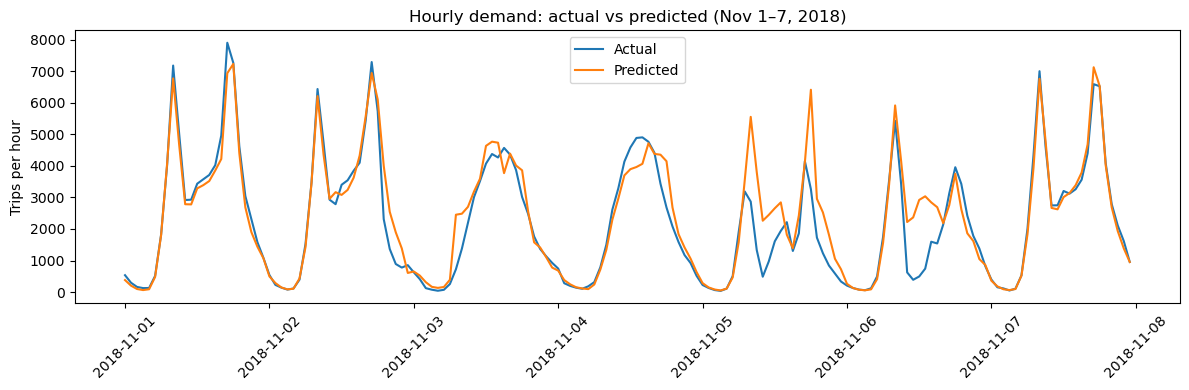

In [5]:
import matplotlib.pyplot as plt

sample = pred_df[
    (pred_df["hour"] >= "2018-11-01") &
    (pred_df["hour"] < "2018-11-08")
].copy()

plt.figure(figsize=(12, 4))
plt.plot(sample["hour"], sample["trips_total"], label="Actual")
plt.plot(sample["hour"], sample["pred_trips"], label="Predicted")
plt.xticks(rotation=45)
plt.ylabel("Trips per hour")
plt.title("Hourly demand: actual vs predicted (Nov 1–7, 2018)")
plt.legend()
plt.tight_layout()
plt.show()


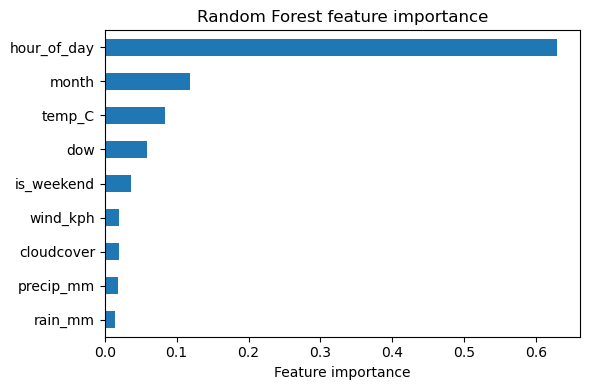

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_importance = pd.Series(importances, index=feature_cols).sort_values()

plt.figure(figsize=(6, 4))
feature_importance.plot(kind="barh")
plt.xlabel("Feature importance")
plt.title("Random Forest feature importance")
plt.tight_layout()
plt.show()


C:\Users\ANBAR\AppData\Local\Temp\ipykernel_17184\4161348392.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("temp_bin")["trips_total"]


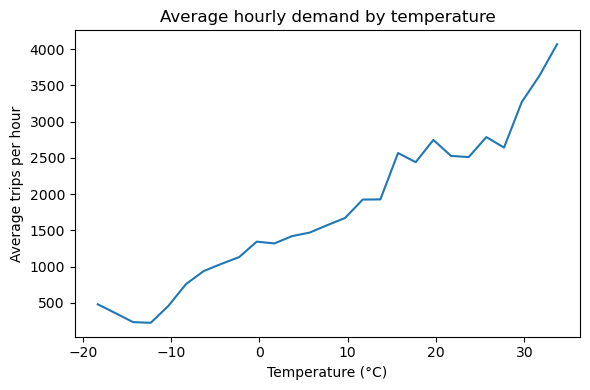

In [7]:
import numpy as np
import matplotlib.pyplot as plt

temperature_bins = np.arange(data["temp_C"].min() - 1, data["temp_C"].max() + 2, 2)
data["temp_bin"] = pd.cut(data["temp_C"], bins=temperature_bins)

temp_demand = (
    data.groupby("temp_bin")["trips_total"]
    .mean()
    .reset_index()
    .dropna()
)

bin_centers = temp_demand["temp_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(6, 4))
plt.plot(bin_centers, temp_demand["trips_total"])
plt.xlabel("Temperature (°C)")
plt.ylabel("Average trips per hour")
plt.title("Average hourly demand by temperature")
plt.tight_layout()
plt.show()


,mean,50%,75%,max
is_rain,,,,
no_rain,2070.653174,1640.0,3206.0,8811.0
rain,1695.395270,1239.0,2594.5,7992.0


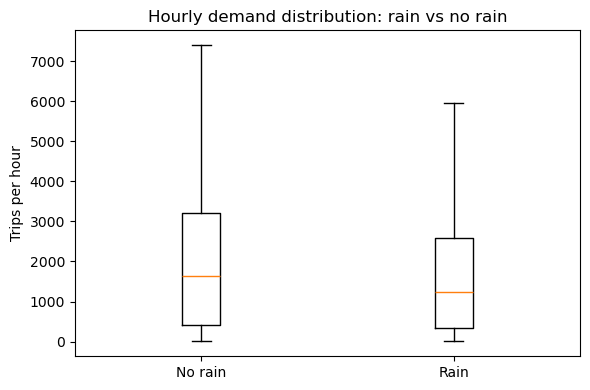

In [8]:
import matplotlib.pyplot as plt

data["is_rain"] = (data["rain_mm"] > 0).astype(int)

rain_stats = (
    data.groupby("is_rain")["trips_total"]
    .describe()[["mean", "50%", "75%", "max"]]
    .rename(index={0: "no_rain", 1: "rain"})
)

display(rain_stats)

rain_groups = [data.loc[data["is_rain"] == 0, "trips_total"],
               data.loc[data["is_rain"] == 1, "trips_total"]]

plt.figure(figsize=(6, 4))
plt.boxplot(rain_groups, labels=["No rain", "Rain"], showfliers=False)
plt.ylabel("Trips per hour")
plt.title("Hourly demand distribution: rain vs no rain")
plt.tight_layout()
plt.show()


C:\Users\ANBAR\AppData\Local\Temp\ipykernel_17184\3824415620.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("wind_bin")["trips_total"]


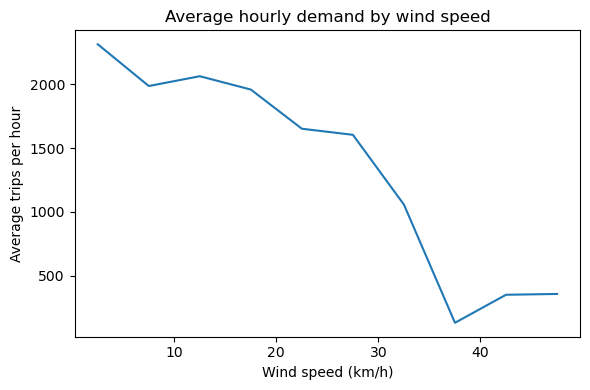

In [9]:
import numpy as np
import matplotlib.pyplot as plt

wind_bins = np.arange(0, data["wind_kph"].max() + 5, 5)
data["wind_bin"] = pd.cut(data["wind_kph"], bins=wind_bins)

wind_demand = (
    data.groupby("wind_bin")["trips_total"]
    .mean()
    .reset_index()
    .dropna()
)

wind_centers = wind_demand["wind_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(6, 4))
plt.plot(wind_centers, wind_demand["trips_total"])
plt.xlabel("Wind speed (km/h)")
plt.ylabel("Average trips per hour")
plt.title("Average hourly demand by wind speed")
plt.tight_layout()
plt.show()


C:\Users\ANBAR\AppData\Local\Temp\ipykernel_17184\253559930.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("cloud_bin")["trips_total"]


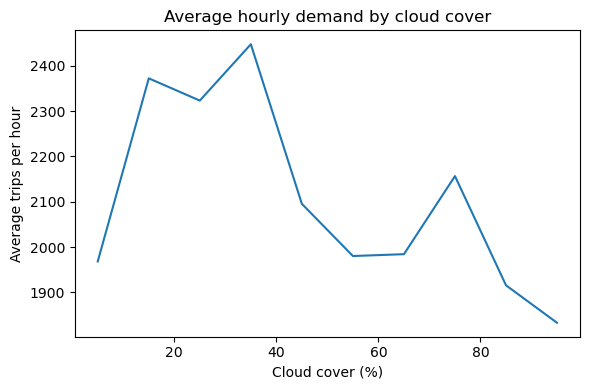

In [10]:
cloud_bins = np.arange(0, 105, 10)
data["cloud_bin"] = pd.cut(data["cloudcover"], bins=cloud_bins)

cloud_demand = (
    data.groupby("cloud_bin")["trips_total"]
    .mean()
    .reset_index()
    .dropna()
)

cloud_centers = cloud_demand["cloud_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(6, 4))
plt.plot(cloud_centers, cloud_demand["trips_total"])
plt.xlabel("Cloud cover (%)")
plt.ylabel("Average trips per hour")
plt.title("Average hourly demand by cloud cover")
plt.tight_layout()
plt.show()


,mean,50%,75%,max
weather_type,,,,
dry,2085.494646,1665.0,3227.0,8811.0
rain,1695.395270,1239.0,2594.5,7992.0
snow_like,588.361111,357.0,1003.0,2441.0


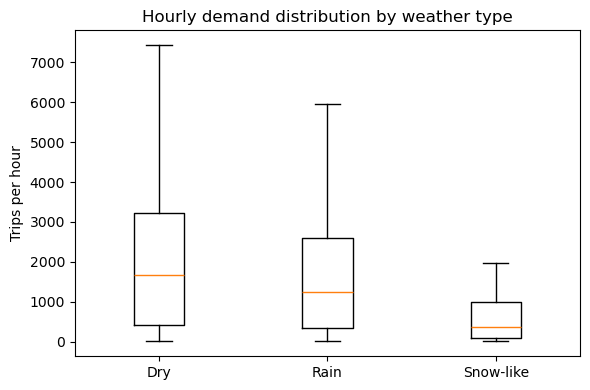

In [11]:
conditions = pd.Series("dry", index=data.index)
conditions[(data["rain_mm"] > 0)] = "rain"
conditions[(data["precip_mm"] > 0) & (data["rain_mm"] == 0)] = "snow_like"
data["weather_type"] = conditions

demand_by_type = (
    data.groupby("weather_type")["trips_total"]
    .describe()[["mean", "50%", "75%", "max"]]
)

display(demand_by_type)

groups = [
    data.loc[data["weather_type"] == "dry", "trips_total"],
    data.loc[data["weather_type"] == "rain", "trips_total"],
    data.loc[data["weather_type"] == "snow_like", "trips_total"],
]

labels = ["Dry", "Rain", "Snow-like"]

plt.figure(figsize=(6, 4))
plt.boxplot(groups, labels=labels, showfliers=False)
plt.ylabel("Trips per hour")
plt.title("Hourly demand distribution by weather type")
plt.tight_layout()
plt.show()


### Step 6 — Add US holidays and analyze holiday vs non-holiday demand

We download this dataset: https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021

**Purpose:** Measure how **public holidays** change the shape and level of demand.

This step:

- loads US holiday dates from `us_holidays_2004_2021.csv`  
- converts the date column to a proper `date` type  
- filters the holiday list to **2018** and merges a daily `is_holiday` flag into the hourly `data` frame  
- compares **holiday vs non-holiday** hours using:
  - summary statistics of `trips_total` (mean, median, upper quantiles)  
  - average **hour-of-day profiles** for holidays vs non-holidays

The resulting plots show:

- lower demand during typical **weekday rush hours** on holidays  
- relatively stronger midday / afternoon use on holidays  
- evidence that part of the “lost” commute demand is simply **not travelling** on those days rather than switching mode.


In [13]:
from pathlib import Path
import pandas as pd

holidays_path = Path("../data/us_holidays_2004_2021.csv")

holidays = pd.read_csv(holidays_path)
print(holidays.columns)
display(holidays.head())


Index(['Date', 'Holiday', 'WeekDay', 'Month', 'Day', 'Year'], dtype='object')


,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008


In [14]:
date_col = "Date"
name_col = "Holiday"

holidays["date"] = pd.to_datetime(holidays[date_col], errors="coerce").dt.date
holidays = holidays.dropna(subset=["date"])

holidays_2018 = holidays[holidays["date"].apply(lambda d: d.year) == 2018].copy()

holidays_2018 = holidays_2018[["date", name_col]].drop_duplicates()
holidays_2018["is_holiday"] = 1

data["date"] = data["hour"].dt.date

data = data.merge(
    holidays_2018[["date", "is_holiday"]],
    on="date",
    how="left",
)

data["is_holiday"] = data["is_holiday"].fillna(0).astype("int8")


In [15]:
holiday_stats = (
    data.groupby("is_holiday")["trips_total"]
    .describe()[["mean", "50%", "75%", "max"]]
    .rename(index={0: "non_holiday", 1: "holiday"})
)

display(holiday_stats)


,mean,50%,75%,max
is_holiday,,,,
non_holiday,2035.387474,1603.0,3154.5,8811.0
holiday,1493.603070,920.0,2422.0,7788.0


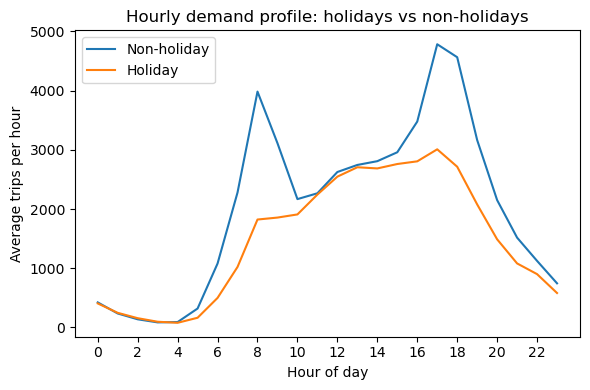

In [16]:
import matplotlib.pyplot as plt

hourly_profile = (
    data.groupby(["is_holiday", "hour_of_day"])["trips_total"]
    .mean()
    .reset_index()
)

non_holiday_profile = hourly_profile[hourly_profile["is_holiday"] == 0]
holiday_profile = hourly_profile[hourly_profile["is_holiday"] == 1]

plt.figure(figsize=(6, 4))
plt.plot(
    non_holiday_profile["hour_of_day"],
    non_holiday_profile["trips_total"],
    label="Non-holiday",
)
plt.plot(
    holiday_profile["hour_of_day"],
    holiday_profile["trips_total"],
    label="Holiday",
)
plt.xlabel("Hour of day")
plt.ylabel("Average trips per hour")
plt.title("Hourly demand profile: holidays vs non-holidays")
plt.xticks(range(0, 24, 2))
plt.legend()
plt.tight_layout()
plt.show()


### Step 7 — Add NBA home games and analyze event-driven uplift

**Purpose:** Explore whether **large evening events** (NBA home games) generate measurable extra bike demand.

Definitely losing some costumers around the "rush-hour", which is why it might be interesting to segment out users to see when we have to meet demand. But let's try to see if sports events does something to the demand. You might want to use a bike home or to the New York Knicks game, and I'm a sports guy so let's check this out. We Import the data: https://www.kaggle.com/datasets/nathanlauga/nba-games

This step:

- loads NBA games from `nba_games.csv`  
- identifies **New York home games** in 2018  
- focuses on **evening hours (18–23)** and aggregates total evening trips per day  
- builds a daily comparison table:
  - evening trips on game day (`evening_trips_game`)  
  - evening trips on the previous day and next day (`evening_trips_prev`, `evening_trips_next`)  
  - difference between game evening and the **average of neighbouring days** (`diff_vs_avg_neighbors`)  
- computes mean and median uplift across all games  
- visualizes **per-game uplift** as a bar chart

This gives a first estimate of **event-driven demand uplift** around sports venues and can inform targeted rebalancing and capacity planning on game nights.


In [27]:
from pathlib import Path
import pandas as pd

nba_path = Path("../data/nba_games.csv")

nba_games = pd.read_csv(nba_path)
print(nba_games.columns)
nba_games.head()


Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')


,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [35]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

evening_data = data[data["hour_of_day"].between(18, 23)].copy()

daily_evening = (
    evening_data.groupby("date")["trips_total"]
    .sum()
    .reset_index()
    .rename(columns={"trips_total": "evening_trips"})
)

game_day_flags = (
    data.groupby("date")["is_nyc_home_game"]
    .max()
    .reset_index()
    .rename(columns={"is_nyc_home_game": "is_game_day"})
)

daily_evening = daily_evening.merge(game_day_flags, on="date", how="left")
daily_evening["is_game_day"] = daily_evening["is_game_day"].fillna(0).astype("int8")

game_evening = daily_evening[daily_evening["is_game_day"] == 1].copy()
display(game_evening.head())


,date,evening_trips,is_game_day
0,2018-01-01,1371,1
1,2018-01-02,4970,1
2,2018-01-03,6700,1
5,2018-01-06,807,1
7,2018-01-08,4600,1


In [36]:
evening_map = dict(zip(daily_evening["date"], daily_evening["evening_trips"]))

rows = []

for _, row in game_evening.iterrows():
    d = row["date"]
    game_trips = row["evening_trips"]
    prev_d = d - timedelta(days=1)
    next_d = d + timedelta(days=1)
    prev_trips = evening_map.get(prev_d)
    next_trips = evening_map.get(next_d)
    avg_neighbors = None
    if (prev_trips is not None) and (next_trips is not None):
        avg_neighbors = (prev_trips + next_trips) / 2
    rows.append(
        {
            "date": d,
            "evening_trips_game": game_trips,
            "evening_trips_prev": prev_trips,
            "evening_trips_next": next_trips,
            "diff_vs_prev": None if prev_trips is None else game_trips - prev_trips,
            "diff_vs_next": None if next_trips is None else game_trips - next_trips,
            "diff_vs_avg_neighbors": None if avg_neighbors is None else game_trips - avg_neighbors,
        }
    )

game_neighbor_compare = pd.DataFrame(rows)
display(game_neighbor_compare.head())


,date,evening_trips_game,evening_trips_prev,evening_trips_next,diff_vs_prev,diff_vs_next,diff_vs_avg_neighbors
0,2018-01-01,1371,NaN,4970,NaN,-3599,NaN
1,2018-01-02,4970,1371.0,6700,3599.0,-1730,934.5
2,2018-01-03,6700,4970.0,437,1730.0,6263,3996.5
3,2018-01-06,807,1259.0,1303,-452.0,-496,-474.0
4,2018-01-08,4600,1303.0,6841,3297.0,-2241,528.0


In [37]:
valid = game_neighbor_compare.dropna(subset=["diff_vs_avg_neighbors"]).copy()

mean_diff = valid["diff_vs_avg_neighbors"].mean()
median_diff = valid["diff_vs_avg_neighbors"].median()

print("Mean difference (game evening minus avg of neighbors):", round(mean_diff, 2))
print("Median difference:", round(median_diff, 2))

display(
    valid[["date", "evening_trips_game", "evening_trips_prev", "evening_trips_next", "diff_vs_avg_neighbors"]]
    .sort_values("date")
    .head(10)
)


Mean difference (game evening minus avg of neighbors): 2030.83
Median difference: 641.25


,date,evening_trips_game,evening_trips_prev,evening_trips_next,diff_vs_avg_neighbors
1,2018-01-02,4970,1371.0,6700,934.5
2,2018-01-03,6700,4970.0,437,3996.5
3,2018-01-06,807,1259.0,1303,-474.0
4,2018-01-08,4600,1303.0,6841,528.0
5,2018-01-10,15196,6841.0,9203,7174.0
6,2018-01-14,2638,3210.0,4430,-1182.0
7,2018-01-15,4430,2638.0,8469,-1123.5
8,2018-01-17,6516,8469.0,7397,-1417.0
9,2018-01-19,7442,7397.0,5846,820.5
10,2018-01-30,7986,9946.0,8515,-1244.5


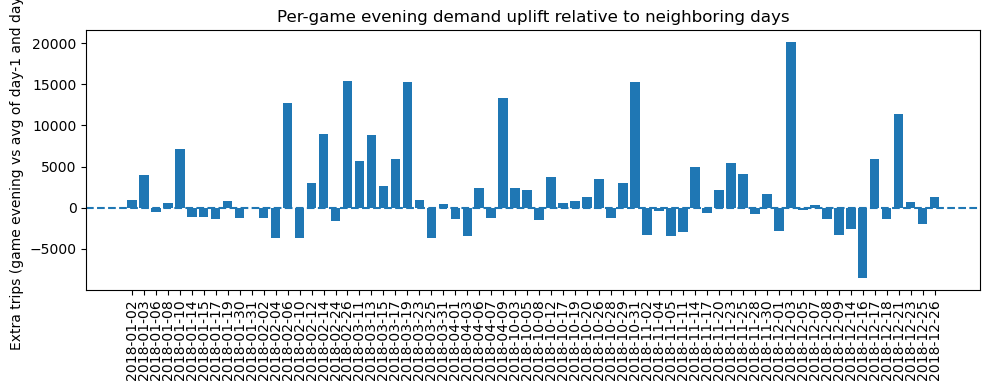

In [38]:
valid_sorted = valid.sort_values("date")

plt.figure(figsize=(10, 4))
plt.bar(
    valid_sorted["date"].astype(str),
    valid_sorted["diff_vs_avg_neighbors"],
)
plt.axhline(0, linestyle="--")
plt.xticks(rotation=90)
plt.ylabel("Extra trips (game evening vs avg of day-1 and day+1)")
plt.title("Per-game evening demand uplift relative to neighboring days")
plt.tight_layout()
plt.show()


Now we move on to trying to segment our users into things like (commuter, leisure, holiday, etc.)

In [12]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

trips_path = Path("../data/Trips_2018.csv")

def haversine_distance_km(lat1, lon1, lat2, lon2):
    radius = 6371.0
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1.0 - a))
    return radius * c

segment_aggregates = {}
sample_frames = []
sample_per_chunk = 5000

reader = pd.read_csv(
    trips_path,
    chunksize=500_000,
    low_memory=True,
    usecols=[
        "starttime","tripduration","usertype",
        "start_station_latitude","start_station_longitude",
        "end_station_latitude","end_station_longitude"
    ],
)

for trip_chunk in reader:
    trip_chunk["started_at"] = pd.to_datetime(trip_chunk["starttime"], errors="coerce")
    trip_chunk = trip_chunk.dropna(subset=["started_at"])
    trip_chunk["hour_of_day"] = trip_chunk["started_at"].dt.hour
    trip_chunk["day_of_week"] = trip_chunk["started_at"].dt.dayofweek
    trip_chunk["month"] = trip_chunk["started_at"].dt.month
    trip_chunk["is_weekend"] = trip_chunk["day_of_week"].isin([5, 6]).astype("int8")

    trip_chunk["duration_min"] = pd.to_numeric(trip_chunk["tripduration"], errors="coerce") / 60.0

    trip_chunk["start_lat"] = pd.to_numeric(trip_chunk["start_station_latitude"], errors="coerce")
    trip_chunk["start_lng"] = pd.to_numeric(trip_chunk["start_station_longitude"], errors="coerce")
    trip_chunk["end_lat"] = pd.to_numeric(trip_chunk["end_station_latitude"], errors="coerce")
    trip_chunk["end_lng"] = pd.to_numeric(trip_chunk["end_station_longitude"], errors="coerce")

    distance_mask = (
        trip_chunk["start_lat"].notna()
        & trip_chunk["start_lng"].notna()
        & trip_chunk["end_lat"].notna()
        & trip_chunk["end_lng"].notna()
    )
    trip_chunk["distance_km"] = np.nan
    trip_chunk.loc[distance_mask, "distance_km"] = haversine_distance_km(
        trip_chunk.loc[distance_mask, "start_lat"],
        trip_chunk.loc[distance_mask, "start_lng"],
        trip_chunk.loc[distance_mask, "end_lat"],
        trip_chunk.loc[distance_mask, "end_lng"],
    )

    trip_chunk["is_subscriber"] = (trip_chunk["usertype"] == "Subscriber").astype("int8")

    segment = pd.Series("other", index=trip_chunk.index, dtype="object")

    commute_mask = (
        (trip_chunk["is_subscriber"] == 1)
        & (trip_chunk["is_weekend"] == 0)
        & (
            trip_chunk["hour_of_day"].between(7, 10)
            | trip_chunk["hour_of_day"].between(16, 19)
        )
        & trip_chunk["duration_min"].between(5, 45)
        & trip_chunk["distance_km"].between(1, 15)
    )

    leisure_mask = (
        (
            (trip_chunk["usertype"] == "Customer")
            | (trip_chunk["is_weekend"] == 1)
        )
        & trip_chunk["hour_of_day"].between(10, 20)
        & (
            (trip_chunk["duration_min"] >= 20)
            | (trip_chunk["distance_km"] >= 3)
        )
    )

    segment.loc[commute_mask] = "commute"
    segment.loc[leisure_mask & ~commute_mask] = "leisure"

    trip_chunk["segment_rule"] = segment

    trip_chunk["duration_min"] = trip_chunk["duration_min"].clip(lower=0)
    trip_chunk["distance_km"] = trip_chunk["distance_km"].clip(lower=0)

    aggregated = (
        trip_chunk.groupby("segment_rule")
        .agg(
            trips_count=("segment_rule", "size"),
            total_duration_min=("duration_min", "sum"),
            total_distance_km=("distance_km", "sum"),
            subscriber_trips=("is_subscriber", "sum"),
            weekend_trips=("is_weekend", "sum"),
        )
    )

    for seg_label, row in aggregated.iterrows():
        if seg_label not in segment_aggregates:
            segment_aggregates[seg_label] = row.to_dict()
        else:
            for key in row.index:
                segment_aggregates[seg_label][key] += row[key]

    sample_chunk = trip_chunk[
        [
            "hour_of_day",
            "day_of_week",
            "month",
            "is_weekend",
            "duration_min",
            "distance_km",
            "is_subscriber",
            "segment_rule",
            "usertype",
        ]
    ].dropna()

    if len(sample_chunk) > sample_per_chunk:
        sample_chunk = sample_chunk.sample(n=sample_per_chunk, random_state=42)

    sample_frames.append(sample_chunk)

segment_summary = pd.DataFrame.from_dict(segment_aggregates, orient="index")
segment_summary["mean_duration_min"] = segment_summary["total_duration_min"] / segment_summary["trips_count"]
segment_summary["mean_distance_km"] = segment_summary["total_distance_km"] / segment_summary["trips_count"]
segment_summary["subscriber_share"] = segment_summary["subscriber_trips"] / segment_summary["trips_count"]
segment_summary["weekend_share"] = segment_summary["weekend_trips"] / segment_summary["trips_count"]
segment_summary["share_of_all_trips"] = segment_summary["trips_count"] / segment_summary["trips_count"].sum()

segment_summary = segment_summary.sort_values("trips_count", ascending=False)

display(segment_summary)


,trips_count,total_duration_min,total_distance_km,subscriber_trips,weekend_trips,mean_duration_min,mean_distance_km,subscriber_share,weekend_share,share_of_all_trips
other,10961032.0,1.326058e+08,1.468229e+07,9967435.0,3203271.0,12.097934,1.339498,0.909352,0.292242,0.624619
commute,5059086.0,7.598886e+07,1.227646e+07,5059086.0,0.0,15.020275,2.426617,1.000000,0.000000,0.288294
leisure,1528221.0,8.058531e+07,4.388423e+06,588304.0,1032025.0,52.731451,2.871589,0.384960,0.675311,0.087086


## Step 8 — Baseline vs enriched models (time, weather, events)

In this step we quantify how much predictive accuracy improves when we add external data sources to the baseline time-only model.

We compare three Random Forest regressors, all trained on the same hourly target (system-wide trips per hour) and the same train/test split (January–October for training, November–December for testing):

1. **Time only**  
   Features: hour of day, day of week, month, weekend indicator.  
   This captures the average daily and weekly pattern but ignores weather and events.

2. **Time + weather**  
   Features: time features + temperature, precipitation, rain, wind speed and cloud cover.  
   This model can react to short-term fluctuations in weather (for example, rain or extreme temperatures).

3. **Time + weather + events**  
   Features: time + weather + indicators for NYC NBA home games (Knicks and Nets, with a focus on evening hours) and, where available, public holidays.  
   This model captures both regular temporal patterns, weather effects and large-scale local events that may affect demand.

We report RMSE, MAE and MAPE on the November–December test period and visualize a sample week to see how the three models differ in practice. This allows us to assess the incremental value of adding weather and event data to the operator’s forecasting pipeline.


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

mask_train = data["hour"] < pd.Timestamp("2018-11-01")
train = data.loc[mask_train].copy()
test = data.loc[~mask_train].copy()

time_features = ["dow", "hour_of_day", "month", "is_weekend"]

weather_features = ["temp_C", "precip_mm", "rain_mm", "wind_kph", "cloudcover"]
weather_features = [c for c in weather_features if c in data.columns]

event_candidates = ["is_nyc_home_game", "is_game_evening_hour", "is_holiday"]
event_features = [c for c in event_candidates if c in data.columns]

def train_and_evaluate(feature_columns, tag):
    X_train = train[feature_columns]
    y_train = train["trips_total"]
    X_test = test[feature_columns]
    y_test = test["trips_total"]

    model = RandomForestRegressor(
        n_estimators=400,
        max_depth=18,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mape = (
        np.abs((y_test - y_pred) / y_test)
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
        .mean()
        * 100
    )

    result = {
        "model": tag,
        "features": ", ".join(feature_columns),
        "rmse": rmse,
        "mae": mae,
        "mape_pct": mape,
    }

    pred_frame = test[["hour", "trips_total"]].copy()
    pred_frame["pred_trips"] = y_pred
    pred_frame["model"] = tag

    return model, result, pred_frame

model_time, res_time, preds_time = train_and_evaluate(time_features, "time_only")

time_weather_features = time_features + weather_features
model_weather, res_weather, preds_weather = train_and_evaluate(time_weather_features, "time_plus_weather")

time_weather_event_features = time_features + weather_features + event_features
time_weather_event_features = list(dict.fromkeys(time_weather_event_features))
model_full, res_full, preds_full = train_and_evaluate(time_weather_event_features, "time_weather_events")

results_table = pd.DataFrame([res_time, res_weather, res_full])
results_table[["rmse", "mae", "mape_pct"]] = results_table[["rmse", "mae", "mape_pct"]].round(3)
display(results_table)

all_predictions = pd.concat([preds_time, preds_weather, preds_full], ignore_index=True)
display(all_predictions.head())


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,features,rmse,mae,mape_pct
0,time_only,"dow, hour_of_day, month, is_weekend",1532.434,998.488,132.193
1,time_plus_weather,"dow, hour_of_day, month, is_weekend, temp_C, p...",1214.829,739.914,97.427
2,time_weather_events,"dow, hour_of_day, month, is_weekend, temp_C, p...",1177.829,728.684,94.361


,hour,trips_total,pred_trips,model
0,2018-11-01 00:00:00,535,466.480469,time_only
1,2018-11-01 01:00:00,295,218.896670,time_only
2,2018-11-01 02:00:00,163,111.575607,time_only
3,2018-11-01 03:00:00,126,65.386829,time_only
4,2018-11-01 04:00:00,129,116.219444,time_only


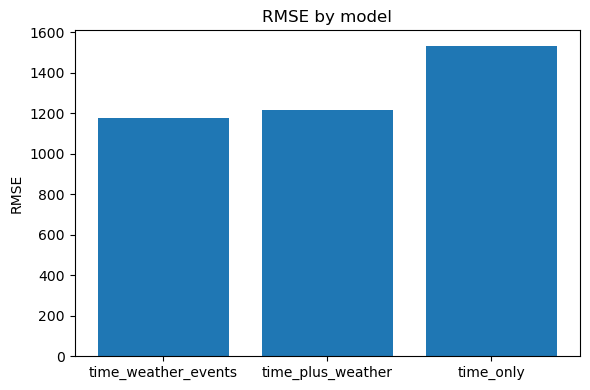

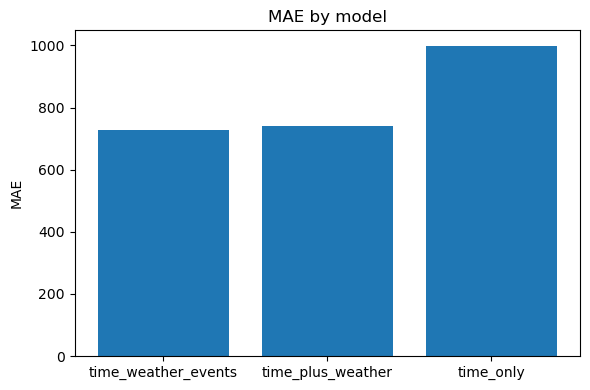

In [57]:
import matplotlib.pyplot as plt

results_sorted = results_table.sort_values("rmse")

plt.figure(figsize=(6, 4))
plt.bar(results_sorted["model"], results_sorted["rmse"])
plt.ylabel("RMSE")
plt.title("RMSE by model")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(results_sorted["model"], results_sorted["mae"])
plt.ylabel("MAE")
plt.title("MAE by model")
plt.tight_layout()
plt.show()


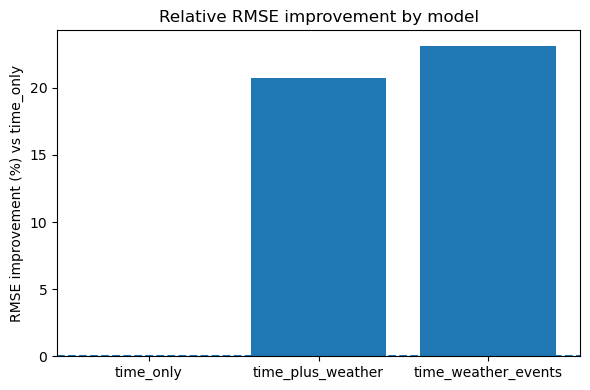

In [58]:
baseline_rmse = float(results_table.loc[results_table["model"] == "time_only", "rmse"].iloc[0])

comparison = results_table.copy()
comparison["rmse_improvement_pct"] = (baseline_rmse - comparison["rmse"]) / baseline_rmse * 100

plt.figure(figsize=(6, 4))
plt.bar(comparison["model"], comparison["rmse_improvement_pct"])
plt.axhline(0, linestyle="--")
plt.ylabel("RMSE improvement (%) vs time_only")
plt.title("Relative RMSE improvement by model")
plt.tight_layout()
plt.show()


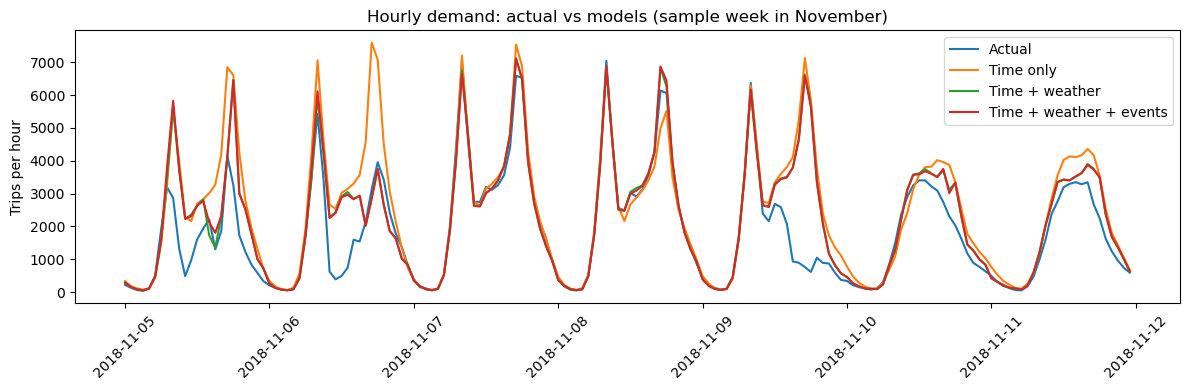

In [59]:
sample_start = pd.Timestamp("2018-11-05")
sample_end = sample_start + pd.Timedelta(days=7)

sample = all_predictions[
    (all_predictions["hour"] >= sample_start) &
    (all_predictions["hour"] < sample_end)
].copy()

sample_actual = sample[sample["model"] == "time_only"].copy()
sample_time = sample[sample["model"] == "time_only"].copy()
sample_weather = sample[sample["model"] == "time_plus_weather"].copy()
sample_full = sample[sample["model"] == "time_weather_events"].copy()

plt.figure(figsize=(12, 4))
plt.plot(sample_actual["hour"], sample_actual["trips_total"], label="Actual")
plt.plot(sample_time["hour"], sample_time["pred_trips"], label="Time only")
plt.plot(sample_weather["hour"], sample_weather["pred_trips"], label="Time + weather")
plt.plot(sample_full["hour"], sample_full["pred_trips"], label="Time + weather + events")
plt.xticks(rotation=45)
plt.ylabel("Trips per hour")
plt.title("Hourly demand: actual vs models (sample week in November)")
plt.legend()
plt.tight_layout()
plt.show()


### Relationship to the prediction challenge model

In the prediction challenge, our group’s main forecasting pipeline operates at the **cluster level** and uses time series models based on historical demand and calendar features. That notebook builds hourly demand per station cluster, applies seasonal baselines and lag-based linear / Ridge models, and generates 24-hour-ahead forecasts for pickups and dropoffs.

In the exploratory component, we work at the **system-wide hourly level** (total trips per hour across all stations) and use a simpler supervised learning setup to study the effect of additional data sources. As a baseline, we train a **time-only Random Forest** model with hour of day, day of week, month and weekend indicators. We then extend this baseline with weather variables and event indicators (NBA home games, optionally holidays) to quantify the incremental value of these external signals.

The exploratory models are therefore **conceptually aligned** with the prediction challenge (forecasting short-term demand from temporal patterns), but they are not the exact same cluster-level model. Instead, they provide a controlled comparison of feature sets (time vs time+weather vs time+weather+events) on system-wide demand, which complements the more detailed cluster-level forecasting results from the main prediction notebook.

We might want to add our own Predition Challenge Model here, but let's look at that

In [60]:
baseline_row = results_table.loc[results_table["model"] == "time_only"].iloc[0]
full_row = results_table.loc[results_table["model"] == "time_weather_events"].iloc[0]

baseline_rmse = baseline_row["rmse"]
baseline_mae = baseline_row["mae"]
baseline_mape = baseline_row["mape_pct"]

full_rmse = full_row["rmse"]
full_mae = full_row["mae"]
full_mape = full_row["mape_pct"]

rmse_improvement_pct = (baseline_rmse - full_rmse) / baseline_rmse * 100
mae_improvement_pct = (baseline_mae - full_mae) / baseline_mae * 100
mape_improvement_pct = (baseline_mape - full_mape) / baseline_mape * 100

print("Baseline (time only) RMSE:", round(baseline_rmse, 3))
print("Full (time + weather + events) RMSE:", round(full_rmse, 3))
print("RMSE improvement (%):", round(rmse_improvement_pct, 2))

print("\nBaseline MAE:", round(baseline_mae, 3))
print("Full MAE:", round(full_mae, 3))
print("MAE improvement (%):", round(mae_improvement_pct, 2))

print("\nBaseline MAPE (%):", round(baseline_mape, 3))
print("Full MAPE (%):", round(full_mape, 3))
print("MAPE improvement (%):", round(mape_improvement_pct, 2))


Baseline (time only) RMSE: 1532.434
Full (time + weather + events) RMSE: 1177.829
RMSE improvement (%): 23.14

Baseline MAE: 998.488
Full MAE: 728.684
MAE improvement (%): 27.02

Baseline MAPE (%): 132.193
Full MAPE (%): 94.361
MAPE improvement (%): 28.62


## Section 2 — Customer segmentation

In this section we shift from **system-level demand** to **who** is using the bikes and **how**.

The goal is to:

- Separate trips into interpretable behavior types (commute, leisure, other)  
- Use **unsupervised clustering** to find data-driven user groups  
- Compare rule-based segments and clusters to see where they agree and where they differ  
- Identify **strong commuter flows** and the stations most involved in repeated commute trips

This segmentation is later linked to weather, holidays, and station typology to discuss which customer groups are hardest to serve.


### Step 1 — Build rule-based trip segments

**Purpose:** Assign each trip to a simple, interpretable segment based on timing, duration, distance, and user type.

We define three segments:

- **Commute**  
  - Subscriber  
  - Weekday (Mon–Fri)  
  - Start time in rush hours: 07–10 or 16–19  
  - Duration between 5 and 45 minutes  
  - Distance between 1 and 15 km  

- **Leisure**  
  - Customer *or* weekend trip  
  - Start time in daytime / evening: 10–20  
  - Duration ≥ 20 minutes or distance ≥ 3 km  

- **Other**  
  - All trips that do not match commute or leisure  
  - Includes short errands, late-night trips, ambiguous patterns, etc.

This yields a **rule-based label** (`segment_rule`) for every trip: `commute`, `leisure`, or `other`.  
It serves as a transparent baseline for later data-driven clustering.


In [18]:
sample_df = pd.concat(sample_frames, ignore_index=True)

sample_df = sample_df.dropna(
    subset=["hour_of_day", "day_of_week", "month", "duration_min", "distance_km"]
)

sample_df["log_duration"] = np.log1p(sample_df["duration_min"])
sample_df["hour_sin"] = np.sin(2 * np.pi * sample_df["hour_of_day"] / 24.0)
sample_df["hour_cos"] = np.cos(2 * np.pi * sample_df["hour_of_day"] / 24.0)

feature_columns_cluster = [
    "hour_sin",
    "hour_cos",
    "day_of_week",
    "month",
    "log_duration",
    "distance_km",
    "is_weekend",
    "is_subscriber",
]

scaler = StandardScaler()
X_cluster = scaler.fit_transform(sample_df[feature_columns_cluster])

kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10,
)
kmeans.fit(X_cluster)

sample_df["cluster"] = kmeans.labels_


### Step 2 — Summarize rule-based segments

**Purpose:** Understand how important each segment is and how they differ behaviorally.

We aggregate over all trips in 2018 and compute, per `segment_rule`:

- `trips_count` and `share_of_all_trips`  
- `mean_duration_min` and `mean_distance_km`  
- `subscriber_share` and `weekend_share`

We then visualize:

- Share of all trips by segment  
- Mean duration by segment  
- Mean distance by segment  

These summaries show, for example:

- how large the commuter segment is relative to leisure and other  
- that leisure trips tend to be longer in time and/or distance  
- that “other” contains many short, flexible trips outside strict commute windows.


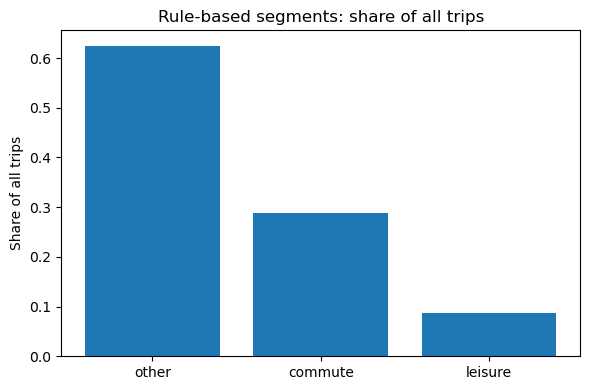

In [19]:
import matplotlib.pyplot as plt

seg = segment_summary.reset_index().rename(columns={"index": "segment"})

plt.figure(figsize=(6, 4))
plt.bar(seg["segment"], seg["share_of_all_trips"])
plt.ylabel("Share of all trips")
plt.title("Rule-based segments: share of all trips")
plt.tight_layout()
plt.show()


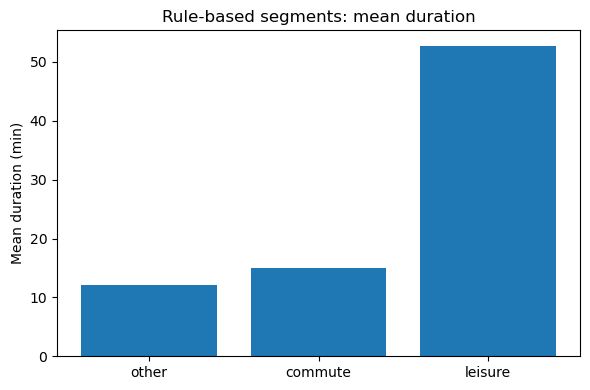

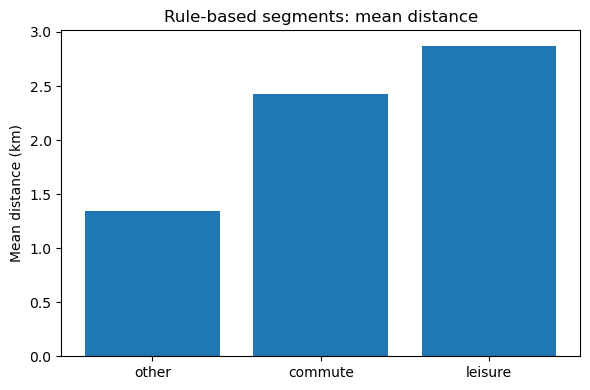

In [20]:
plt.figure(figsize=(6, 4))
plt.bar(seg["segment"], seg["mean_duration_min"])
plt.ylabel("Mean duration (min)")
plt.title("Rule-based segments: mean duration")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(seg["segment"], seg["mean_distance_km"])
plt.ylabel("Mean distance (km)")
plt.title("Rule-based segments: mean distance")
plt.tight_layout()
plt.show()


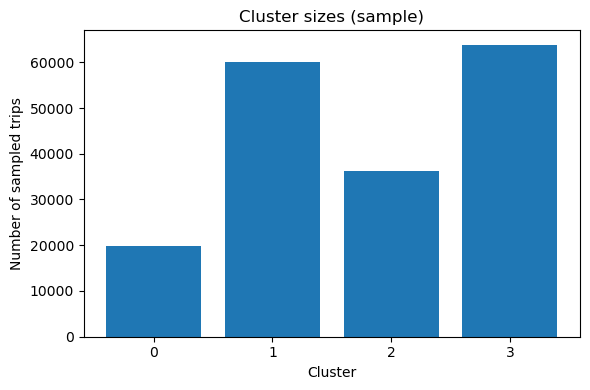

In [21]:
cluster_counts = sample_df["cluster"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.xlabel("Cluster")
plt.ylabel("Number of sampled trips")
plt.title("Cluster sizes (sample)")
plt.tight_layout()
plt.show()


<Figure size 700x400 with 0 Axes>

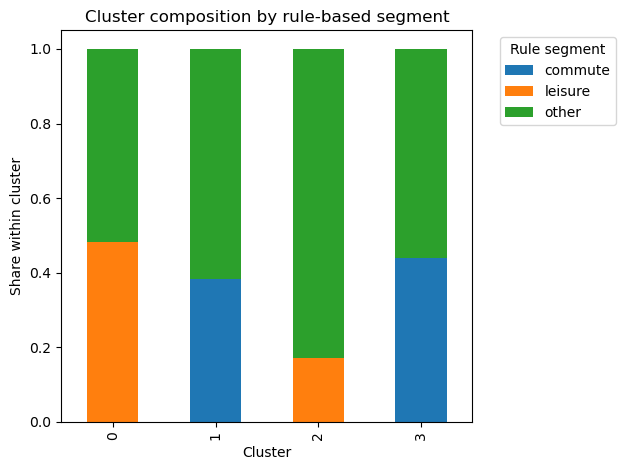

In [22]:
crosstab = pd.crosstab(
    sample_df["cluster"],
    sample_df["segment_rule"],
    normalize="index",
)

crosstab.index = crosstab.index.astype(str)

plt.figure(figsize=(7, 4))
crosstab.plot(kind="bar", stacked=True)
plt.xlabel("Cluster")
plt.ylabel("Share within cluster")
plt.title("Cluster composition by rule-based segment")
plt.legend(title="Rule segment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


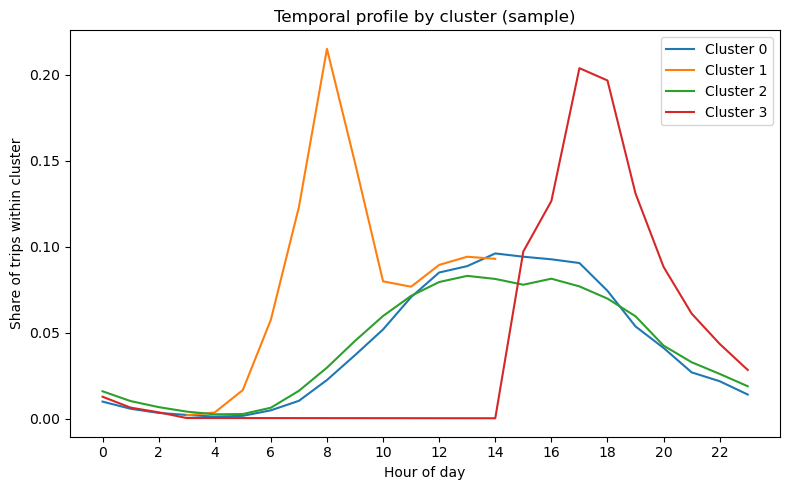

In [23]:
hour_cluster = (
    sample_df.groupby(["cluster", "hour_of_day"])
    .size()
    .rename("trips")
    .reset_index()
)

total_per_cluster = hour_cluster.groupby("cluster")["trips"].transform("sum")
hour_cluster["share"] = hour_cluster["trips"] / total_per_cluster

clusters_sorted = sorted(hour_cluster["cluster"].unique())

plt.figure(figsize=(8, 5))
for cl in clusters_sorted:
    sub = hour_cluster[hour_cluster["cluster"] == cl]
    plt.plot(sub["hour_of_day"], sub["share"], label=f"Cluster {cl}")
plt.xlabel("Hour of day")
plt.ylabel("Share of trips within cluster")
plt.title("Temporal profile by cluster (sample)")
plt.xticks(range(0, 24, 2))
plt.legend()
plt.tight_layout()
plt.show()


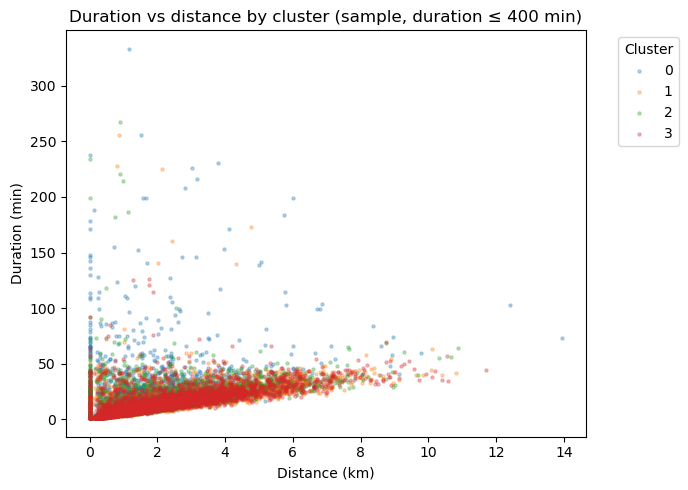

In [26]:
import matplotlib.pyplot as plt

filtered = sample_df[
    (sample_df["duration_min"].notna())
    & (sample_df["distance_km"].notna())
    & (sample_df["duration_min"] <= 400)
    & (sample_df["duration_min"] >= 0)
    & (sample_df["distance_km"] >= 0)
]

scatter_sample = filtered.sample(n=min(20000, len(filtered)), random_state=42)

plt.figure(figsize=(7, 5))
for cl in sorted(scatter_sample["cluster"].unique()):
    sub = scatter_sample[scatter_sample["cluster"] == cl]
    plt.scatter(sub["distance_km"], sub["duration_min"], alpha=0.3, s=5, label=f"{cl}")
plt.xlabel("Distance (km)")
plt.ylabel("Duration (min)")
plt.title("Duration vs distance by cluster (sample, duration ≤ 400 min)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### Step 5 — Identify strong commuter routes

**Purpose:** Move from individual trips to **repeated commuter flows** between stations.

We focus on trips that are:

- Subscriber  
- Weekday  
- Rush-hour (07–10 or 16–19)  
- Duration between 5 and 60 minutes  

For this subset, we:

- aggregate counts by origin–destination pair (`start_station_id`, `end_station_id`)  
- identify **strong commuter routes** with at least a minimum number of trips (e.g. ≥ 200 in 2018)  
- mark trips on these routes as `strong_commute` and keep a sample in `strong_commute_df`

We then visualize:

- top commuter routes by trip count  
- start-time distribution of strong-commute trips  
- duration distribution of strong-commute trips (with outliers filtered)

This refines the commuter segment to those OD pairs that behave like **stable home–work corridors** rather than one-off rush-hour rides.


In [39]:
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict

trips_path = Path("../data/Trips_2018.csv")

route_counts = defaultdict(int)

reader = pd.read_csv(
    trips_path,
    chunksize=500_000,
    low_memory=True,
    usecols=[
        "starttime","tripduration","usertype",
        "start_station_id","end_station_id"
    ],
)

for chunk in reader:
    chunk["started_at"] = pd.to_datetime(chunk["starttime"], errors="coerce")
    chunk = chunk.dropna(subset=["started_at"])
    chunk["hour_of_day"] = chunk["started_at"].dt.hour
    chunk["day_of_week"] = chunk["started_at"].dt.dayofweek
    chunk["is_weekend"] = chunk["day_of_week"].isin([5, 6]).astype("int8")

    chunk["duration_min"] = pd.to_numeric(chunk["tripduration"], errors="coerce") / 60.0

    mask = (
        (chunk["usertype"] == "Subscriber")
        & (chunk["is_weekend"] == 0)
        & (
            chunk["hour_of_day"].between(7, 10)
            | chunk["hour_of_day"].between(16, 19)
        )
        & chunk["duration_min"].between(5, 60)
        & chunk["start_station_id"].notna()
        & chunk["end_station_id"].notna()
    )

    cand = chunk.loc[mask, ["start_station_id","end_station_id"]].astype("Int32")

    grp = cand.groupby(["start_station_id","end_station_id"]).size()

    for (sid_start, sid_end), cnt in grp.items():
        route_counts[(int(sid_start), int(sid_end))] += int(cnt)

routes_df = (
    pd.DataFrame(
        [(k[0], k[1], v) for k, v in route_counts.items()],
        columns=["start_station_id","end_station_id","trip_count"]
    )
    .sort_values("trip_count", ascending=False)
)

min_commute_trips = 200
commuter_routes = routes_df[routes_df["trip_count"] >= min_commute_trips].copy()
commuter_routes_set = set(
    zip(commuter_routes["start_station_id"], commuter_routes["end_station_id"])
)

print("Total candidate commuter routes:", len(routes_df))
print("Strong commuter routes (trip_count >= {}): {}".format(
    min_commute_trips, len(commuter_routes)
))
display(commuter_routes.head(20))


Total candidate commuter routes: 268629
Strong commuter routes (trip_count >= 200): 4337


,start_station_id,end_station_id,trip_count
35763,519,498,3519
35757,519,491,2999
35758,519,492,2969
33882,505,519,2685
31370,491,519,2380
35746,519,477,2317
31120,490,519,2188
20409,402,519,2101
4634,244,324,2080
35685,519,379,1882


In [40]:
strong_commute_counts = {"strong_commute": 0, "other": 0}
strong_commute_samples = []

reader2 = pd.read_csv(
    trips_path,
    chunksize=500_000,
    low_memory=True,
    usecols=[
        "starttime","tripduration","usertype",
        "start_station_id","end_station_id"
    ],
)

sample_per_chunk = 5000

for chunk in reader2:
    chunk["started_at"] = pd.to_datetime(chunk["starttime"], errors="coerce")
    chunk = chunk.dropna(subset=["started_at"])
    chunk["hour_of_day"] = chunk["started_at"].dt.hour
    chunk["day_of_week"] = chunk["started_at"].dt.dayofweek
    chunk["is_weekend"] = chunk["day_of_week"].isin([5, 6]).astype("int8")

    chunk["duration_min"] = pd.to_numeric(chunk["tripduration"], errors="coerce") / 60.0

    chunk = chunk.dropna(
        subset=["duration_min","start_station_id","end_station_id","usertype"]
    )

    chunk["start_station_id"] = chunk["start_station_id"].astype("Int32")
    chunk["end_station_id"] = chunk["end_station_id"].astype("Int32")

    route_key = list(
        zip(chunk["start_station_id"].to_numpy(), chunk["end_station_id"].to_numpy())
    )
    chunk["is_strong_commute"] = [
        1 if rk in commuter_routes_set else 0 for rk in route_key
    ]

    mask_strong = (
        (chunk["is_strong_commute"] == 1)
        & (chunk["usertype"] == "Subscriber")
        & (chunk["is_weekend"] == 0)
        & (
            chunk["hour_of_day"].between(7, 10)
            | chunk["hour_of_day"].between(16, 19)
        )
        & chunk["duration_min"].between(5, 60)
    )

    strong_commute_counts["strong_commute"] += int(mask_strong.sum())
    strong_commute_counts["other"] += int(len(chunk) - mask_strong.sum())

    sample_chunk = chunk.loc[
        mask_strong,
        [
            "started_at",
            "hour_of_day",
            "day_of_week",
            "duration_min",
            "start_station_id",
            "end_station_id",
        ],
    ]

    if len(sample_chunk) > sample_per_chunk:
        sample_chunk = sample_chunk.sample(n=sample_per_chunk, random_state=42)

    if len(sample_chunk) > 0:
        strong_commute_samples.append(sample_chunk)

strong_commute_df = pd.concat(strong_commute_samples, ignore_index=True)

print("Strong commute trips (estimated):", strong_commute_counts["strong_commute"])
print("Other trips (in these chunks):", strong_commute_counts["other"])
display(strong_commute_df.head())


Strong commute trips (estimated): 1540593
Other trips (in these chunks): 16005249


,started_at,hour_of_day,day_of_week,duration_min,start_station_id,end_station_id
0,2018-01-11 10:06:37.660,10,3,9.233333,492,519
1,2018-01-25 08:50:21.705,8,3,7.933333,127,426
2,2018-01-11 08:19:55.803,8,3,6.200000,499,305
3,2018-01-26 07:19:44.099,7,4,7.466667,515,524
4,2018-01-31 08:23:35.549,8,2,9.150000,490,447


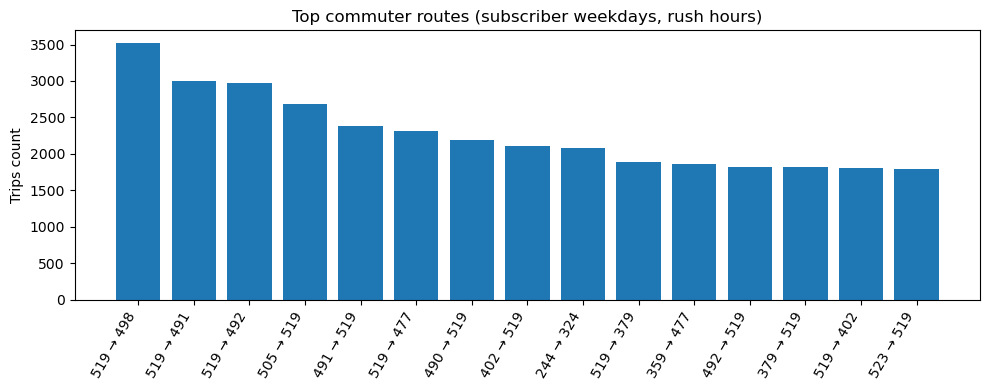

In [41]:
import matplotlib.pyplot as plt

top_n = 15
top_routes = commuter_routes.head(top_n).copy()
top_routes["route"] = top_routes["start_station_id"].astype(str) + " → " + top_routes["end_station_id"].astype(str)

plt.figure(figsize=(10, 4))
plt.bar(top_routes["route"], top_routes["trip_count"])
plt.xticks(rotation=60, ha="right")
plt.ylabel("Trips count")
plt.title("Top commuter routes (subscriber weekdays, rush hours)")
plt.tight_layout()
plt.show()


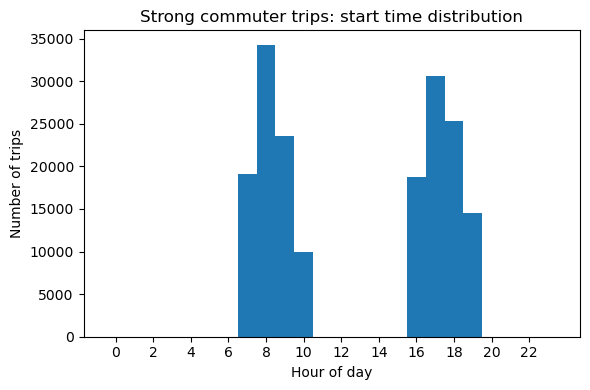

In [42]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(strong_commute_df["hour_of_day"], bins=np.arange(-0.5, 24.5, 1))
plt.xticks(range(0, 24, 2))
plt.xlabel("Hour of day")
plt.ylabel("Number of trips")
plt.title("Strong commuter trips: start time distribution")
plt.tight_layout()
plt.show()


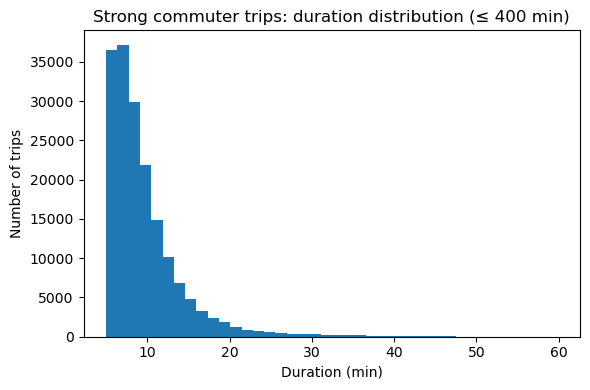

In [44]:
filtered_commute = strong_commute_df[
    (strong_commute_df["duration_min"] >= 0)
    & (strong_commute_df["duration_min"] <= 400)
]

plt.figure(figsize=(6, 4))
plt.hist(filtered_commute["duration_min"], bins=40)
plt.xlabel("Duration (min)")
plt.ylabel("Number of trips")
plt.title("Strong commuter trips: duration distribution (≤ 400 min)")
plt.tight_layout()
plt.show()


### Step 6 — Spatial view: strong commuter stations and corridors

**Purpose:** Show where commuters start and end their rides in the city.

We:

- build a **station coordinate table** with latitude/longitude per station  
- compute, for each station:
  - `start_commute_trips`: strong-commute departures  
  - `end_commute_trips`: strong-commute arrivals  
  - `commute_trips`: total strong-commute involvement  

We then create two spatial views:

1. **Global commuter heatmap (scatter)**  
   - all stations with `commute_trips > 0`  
   - point size and/or color scaled by `commute_trips`  

2. **Top commuter mini-network**  
   - select the top N stations by `commute_trips`  
   - draw lines between them for the strongest routes  
   - label station IDs on the plot  

These maps highlight:

- main **commuter hubs** in the network  
- key **corridors** where demand is highly directional in rush hours  
- natural candidates for prioritised capacity and rebalancing.


In [45]:
from pathlib import Path
import pandas as pd
import numpy as np

trips_path = Path("../data/Trips_2018.csv")

station_coords = {}

reader = pd.read_csv(
    trips_path,
    chunksize=500_000,
    low_memory=True,
    usecols=[
        "start_station_id","start_station_latitude","start_station_longitude",
        "end_station_id","end_station_latitude","end_station_longitude",
    ],
)

for chunk in reader:
    start_part = chunk[
        ["start_station_id","start_station_latitude","start_station_longitude"]
    ].dropna()
    start_part = start_part.drop_duplicates("start_station_id")
    for row in start_part.itertuples(index=False):
        sid = int(row.start_station_id)
        if sid not in station_coords:
            station_coords[sid] = (float(row.start_station_latitude), float(row.start_station_longitude))

    end_part = chunk[
        ["end_station_id","end_station_latitude","end_station_longitude"]
    ].dropna()
    end_part = end_part.drop_duplicates("end_station_id")
    for row in end_part.itertuples(index=False):
        sid = int(row.end_station_id)
        if sid not in station_coords:
            station_coords[sid] = (float(row.end_station_latitude), float(row.end_station_longitude))

stations_df = pd.DataFrame(
    [
        {"station_id": sid, "lat": coords[0], "lon": coords[1]}
        for sid, coords in station_coords.items()
    ]
)

start_strength = (
    commuter_routes.groupby("start_station_id")["trip_count"]
    .sum()
    .rename("start_commute_trips")
)
end_strength = (
    commuter_routes.groupby("end_station_id")["trip_count"]
    .sum()
    .rename("end_commute_trips")
)

station_strength = stations_df.merge(
    start_strength, left_on="station_id", right_index=True, how="left"
).merge(
    end_strength, left_on="station_id", right_index=True, how="left"
)

station_strength["start_commute_trips"] = station_strength["start_commute_trips"].fillna(0)
station_strength["end_commute_trips"] = station_strength["end_commute_trips"].fillna(0)
station_strength["commute_trips"] = (
    station_strength["start_commute_trips"] + station_strength["end_commute_trips"]
)

display(station_strength.head())


,station_id,lat,lon,start_commute_trips,end_commute_trips,commute_trips
0,72,40.767272,-73.993929,5315.0,4734.0,10049.0
1,79,40.719116,-74.006667,974.0,387.0,1361.0
2,82,40.711174,-74.000165,0.0,0.0,0.0
3,83,40.683826,-73.976323,0.0,291.0,291.0
4,119,40.696089,-73.978034,0.0,0.0,0.0


In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

gdf = gpd.GeoDataFrame(
    station_strength,
    geometry=gpd.points_from_xy(station_strength["lon"], station_strength["lat"]),
    crs="EPSG:4326",
)

gdf_web = gdf.to_crs(epsg=3857)

nonzero = gdf_web[gdf_web["commute_trips"] > 0].copy()
nonzero["size"] = 5 + 20 * (nonzero["commute_trips"] / nonzero["commute_trips"].max())

ax = nonzero.plot(
    figsize=(8, 8),
    column="commute_trips",
    markersize=nonzero["size"],
    alpha=0.8,
    legend=True,
)

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.title("Strong commuter stations (point size and color = commuter trips)")
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'geopandas'

Can try at home, I don't get to download anything from work

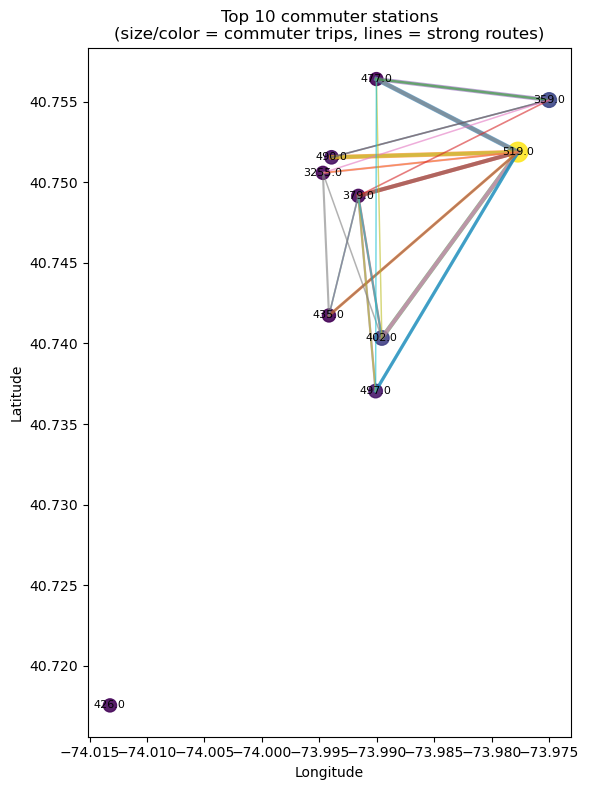

In [48]:
import matplotlib.pyplot as plt

top_n_stations = 10

nonzero = station_strength[station_strength["commute_trips"] > 0].copy()
top_stations = nonzero.nlargest(top_n_stations, "commute_trips").copy()

top_ids = set(top_stations["station_id"].tolist())

top_routes = (
    commuter_routes[
        commuter_routes["start_station_id"].isin(top_ids)
        & commuter_routes["end_station_id"].isin(top_ids)
    ]
    .sort_values("trip_count", ascending=False)
)

top_routes = top_routes.head(30).copy()

station_pos = top_stations.set_index("station_id")[["lon","lat"]]

plt.figure(figsize=(6, 8))

for _, row in top_routes.iterrows():
    sid_start = row["start_station_id"]
    sid_end = row["end_station_id"]
    if sid_start in station_pos.index and sid_end in station_pos.index:
        x0, y0 = station_pos.loc[sid_start, ["lon","lat"]]
        x1, y1 = station_pos.loc[sid_end, ["lon","lat"]]
        lw = 0.5 + 3 * (row["trip_count"] / top_routes["trip_count"].max())
        plt.plot([x0, x1], [y0, y1], linewidth=lw, alpha=0.6)

sizes = 40 + 160 * (top_stations["commute_trips"] / top_stations["commute_trips"].max())
plt.scatter(
    top_stations["lon"],
    top_stations["lat"],
    s=sizes,
    c=top_stations["commute_trips"],
    alpha=0.9,
)

for _, row in top_stations.iterrows():
    plt.text(
        row["lon"],
        row["lat"],
        str(row["station_id"]),
        fontsize=8,
        ha="center",
        va="center",
    )

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Top {top_n_stations} commuter stations\n(size/color = commuter trips, lines = strong routes)")
plt.tight_layout()
plt.show()


## Section 3 — Station typology via temporal clustering

In the last step we segmented **trips** and **routes**.  
Here we focus on **stations** and ask:

- Which stations behave like **commuter hubs**?
- Which ones are more **weekend / leisure** oriented?
- Are there stations with **evening / nightlife** patterns?
- How are these types distributed in space?

We do this by building a **temporal fingerprint** for each station and clustering stations with similar hourly profiles.


### Step 1 — Build hourly departure profiles per station

**Purpose:** Construct a compact time profile for each station.

This step:

- streams the trips file in chunks  
- extracts `starttime` and `start_station_id`  
- derives:
  - `hour_of_day` (0–23)  
  - `day_of_week` (0 = Monday, …, 6 = Sunday)  
  - `is_weekend` (1 for Saturday/Sunday, 0 otherwise)  
- counts departures by `(start_station_id, is_weekend, hour_of_day)`

The result is a long-format table where each row is:

- station × weekday/weekend × hour-of-day  
- with a corresponding trip count.


### Step 2 — Pivot, normalize, and cluster stations

**Purpose:** Turn raw counts into normalized temporal fingerprints and cluster them.

This step:

- pivots the long table into wide format with one row per station and 48 columns:
  - `wd_00`–`wd_23`: weekday hourly shares  
  - `we_00`–`we_23`: weekend hourly shares  
- fills missing entries with zero  
- normalizes **per station** so that all 48 hourly values sum to 1  
  - focusing on the *shape* of demand, not volume  
- applies **k-means** clustering (e.g. `k = 4`) on the normalized profiles  
- stores the assigned cluster label in `station_clusters["cluster"]`

Each station is now assigned to a **temporal type** based on its typical hourly pattern.


In [49]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

trips_path = Path("../data/Trips_2018.csv")

profiles = {}

reader = pd.read_csv(
    trips_path,
    chunksize=500_000,
    low_memory=True,
    usecols=["starttime", "start_station_id"],
)

for chunk in reader:
    chunk["started_at"] = pd.to_datetime(chunk["starttime"], errors="coerce")
    chunk = chunk.dropna(subset=["started_at", "start_station_id"])
    chunk["start_station_id"] = pd.to_numeric(chunk["start_station_id"], errors="coerce")
    chunk = chunk.dropna(subset=["start_station_id"])
    chunk["start_station_id"] = chunk["start_station_id"].astype("Int32")

    chunk["hour_of_day"] = chunk["started_at"].dt.hour
    chunk["day_of_week"] = chunk["started_at"].dt.dayofweek
    chunk["is_weekend"] = chunk["day_of_week"].isin([5, 6]).astype("int8")

    grouped = (
        chunk.groupby(["start_station_id", "is_weekend", "hour_of_day"])
        .size()
    )

    for (sid, is_weekend, hour), count in grouped.items():
        key = (int(sid), int(is_weekend), int(hour))
        profiles[key] = profiles.get(key, 0) + int(count)

profiles_df = pd.DataFrame(
    [
        {
            "start_station_id": k[0],
            "is_weekend": k[1],
            "hour_of_day": k[2],
            "trips": v,
        }
        for k, v in profiles.items()
    ]
)

profiles_df["profile_col"] = np.where(
    profiles_df["is_weekend"] == 0,
    "wd_" + profiles_df["hour_of_day"].astype(str).str.zfill(2),
    "we_" + profiles_df["hour_of_day"].astype(str).str.zfill(2),
)

profiles_wide = profiles_df.pivot(
    index="start_station_id",
    columns="profile_col",
    values="trips",
).fillna(0)

profiles_wide = profiles_wide.sort_index(axis=1)

total_trips = profiles_wide.sum(axis=1)
nonzero = total_trips > 0
profiles_norm = profiles_wide.copy()
profiles_norm.loc[nonzero] = profiles_norm.loc[nonzero].div(total_trips[nonzero], axis=0)

n_clusters = 4
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init=10,
)
cluster_labels = kmeans.fit_predict(profiles_norm.values)

station_clusters = profiles_norm.copy()
station_clusters["cluster"] = cluster_labels

cluster_sizes = station_clusters["cluster"].value_counts().sort_index()
print("Stations per cluster:")
print(cluster_sizes)

station_clusters.head()


Stations per cluster:
cluster
0     98
1    318
2    401
3      1
Name: count, dtype: int64


profile_col,wd_00,wd_01,wd_02,wd_03,wd_04,wd_05,wd_06,wd_07,wd_08,wd_09,...,we_15,we_16,we_17,we_18,we_19,we_20,we_21,we_22,we_23,cluster
start_station_id,,,,,,,,,,,,,,,,,,,,,
72,0.006015,0.003697,0.002135,0.000963,0.002343,0.005780,0.010832,0.041297,0.081135,0.069236,...,0.022445,0.023513,0.022289,0.019034,0.012212,0.008541,0.004739,0.004635,0.003697,2
79,0.004118,0.001985,0.000993,0.000331,0.000404,0.004081,0.009229,0.016545,0.052394,0.042650,...,0.017942,0.019340,0.015295,0.014891,0.010442,0.009118,0.005920,0.004339,0.003750,2
82,0.003426,0.002643,0.001468,0.000587,0.000489,0.002838,0.031125,0.033376,0.047764,0.068415,...,0.020750,0.022512,0.018792,0.016737,0.013507,0.008319,0.006264,0.003915,0.003426,2
83,0.006852,0.003883,0.001218,0.000685,0.000533,0.001066,0.020329,0.024821,0.027257,0.022156,...,0.026725,0.026953,0.027562,0.023451,0.017664,0.013933,0.012182,0.008908,0.008147,2
119,0.001234,0.003394,0.001851,0.000926,0.002160,0.008948,0.050293,0.046591,0.090096,0.064795,...,0.013576,0.015427,0.017896,0.012650,0.013885,0.009256,0.008331,0.006788,0.003703,1


### Step 3 — Inspect cluster sizes and temporal profiles

**Purpose:** Understand what each cluster looks like in time.

This step:

- counts how many stations are in each cluster (bar plot: stations per cluster)  
- computes the **average weekday profile** per cluster:
  - mean of `wd_00`–`wd_23` within each cluster  
  - plotted as hourly curves (0–23) for weekdays  
- computes the **average weekend profile** per cluster:
  - mean of `we_00`–`we_23` within each cluster  
  - plotted as hourly curves (0–23) for weekends  

From these plots we can visually identify:

- clusters with strong weekday AM/PM peaks (commuter hubs)  
- clusters with weekend midday peaks (leisure / parks / tourist areas)  
- more “flat” or low-intensity clusters.


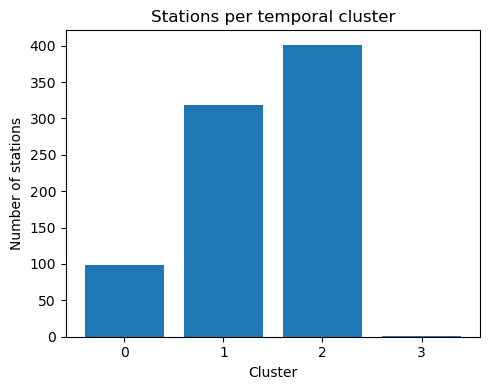

In [50]:
import matplotlib.pyplot as plt

cluster_sizes = station_clusters["cluster"].value_counts().sort_index()

plt.figure(figsize=(5, 4))
plt.bar(cluster_sizes.index.astype(str), cluster_sizes.values)
plt.xlabel("Cluster")
plt.ylabel("Number of stations")
plt.title("Stations per temporal cluster")
plt.tight_layout()
plt.show()


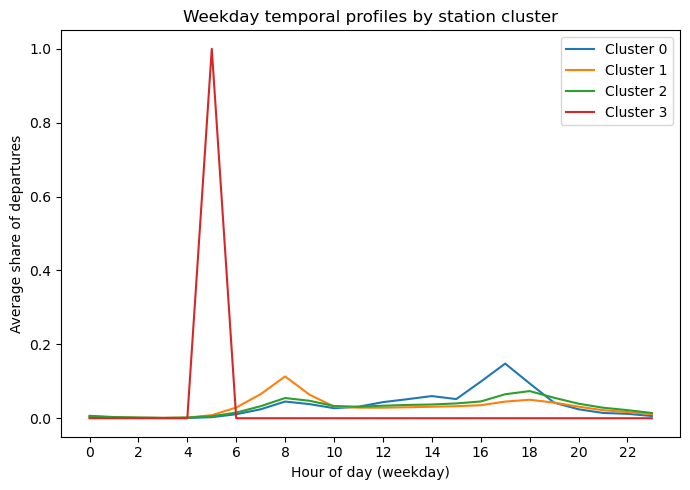

In [51]:
wd_cols = [c for c in station_clusters.columns if c.startswith("wd_")]
we_cols = [c for c in station_clusters.columns if c.startswith("we_")]

cluster_profiles_wd = (
    station_clusters.groupby("cluster")[wd_cols]
    .mean()
)

hours = [int(c.split("_")[1]) for c in wd_cols]

plt.figure(figsize=(7, 5))
for cl in sorted(cluster_profiles_wd.index):
    vals = cluster_profiles_wd.loc[cl].values
    plt.plot(hours, vals, label=f"Cluster {cl}")
plt.xlabel("Hour of day (weekday)")
plt.ylabel("Average share of departures")
plt.title("Weekday temporal profiles by station cluster")
plt.xticks(range(0, 24, 2))
plt.legend()
plt.tight_layout()
plt.show()


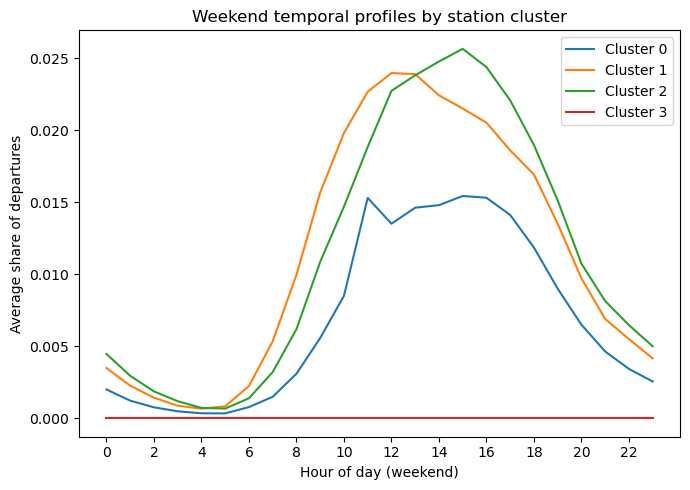

In [52]:
cluster_profiles_we = (
    station_clusters.groupby("cluster")[we_cols]
    .mean()
)

hours_we = [int(c.split("_")[1]) for c in we_cols]

plt.figure(figsize=(7, 5))
for cl in sorted(cluster_profiles_we.index):
    vals = cluster_profiles_we.loc[cl].values
    plt.plot(hours_we, vals, label=f"Cluster {cl}")
plt.xlabel("Hour of day (weekend)")
plt.ylabel("Average share of departures")
plt.title("Weekend temporal profiles by station cluster")
plt.xticks(range(0, 24, 2))
plt.legend()
plt.tight_layout()
plt.show()


### Step 4 — Map station types in space

**Purpose:** See where the different station types are located in the city.

This step:

- merges `station_clusters` (cluster labels) with `stations_df` (station coordinates)  
- creates a scatter plot of station locations:
  - `lon` on the x-axis, `lat` on the y-axis  
  - point color = cluster id  

The resulting map shows:

- where **commuter hubs** are concentrated (e.g. downtown, major transit areas)  
- where **weekend / leisure** stations appear (parks, waterfronts, tourist zones)  
- how mixed-use or low-intensity station types are distributed across the network.


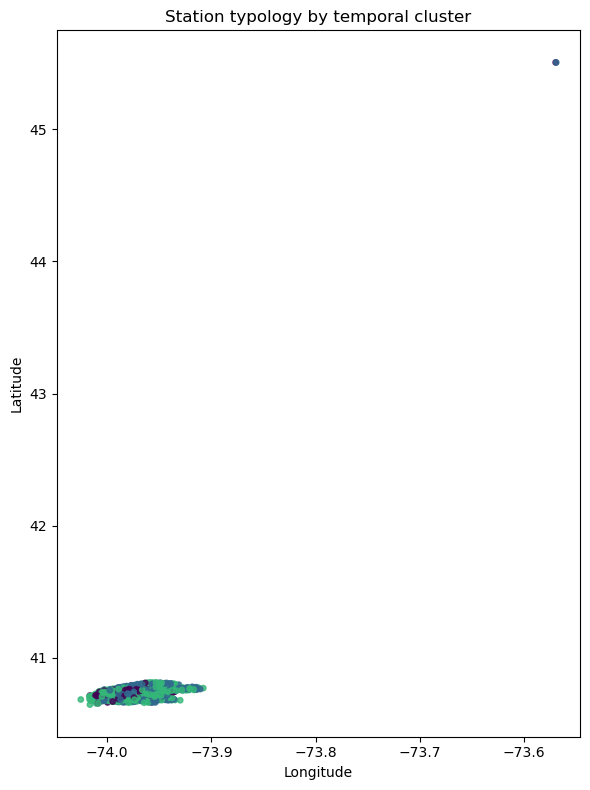

In [53]:
import matplotlib.pyplot as plt

stations_with_cluster = (
    station_clusters[["cluster"]]
    .reset_index()
    .rename(columns={"start_station_id": "station_id"})
    .merge(stations_df, on="station_id", how="inner")
)

plt.figure(figsize=(6, 8))
sc = plt.scatter(
    stations_with_cluster["lon"],
    stations_with_cluster["lat"],
    c=stations_with_cluster["cluster"],
    s=15,
    alpha=0.8,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Station typology by temporal cluster")
plt.tight_layout()
plt.show()


### Step 5 — Interpreting the station clusters

**Purpose:** Translate numeric clusters into meaningful station types.

We interpret clusters by inspecting their average weekday/weekend profiles and spatial patterns:

- **Cluster 0 – Weekday commuter hubs**  
  - Strong peaks around 08–09 and 17–18 on weekdays  
  - Low relative use at night and on weekends  
  - Typically near large office areas or transit hubs.

- **Cluster 1 – Weekend / leisure destinations**  
  - Flatter weekdays, strong midday peaks on weekends  
  - Often near parks, waterfronts, and tourist attractions.

- **Cluster 2 – Mixed-use / all-day stations**  
  - Moderate demand throughout the day on both weekdays and weekends  
  - Typical of dense residential or mixed residential–commercial areas.

- **Cluster 3 – Low-intensity / off-peak stations**  
  - Low overall usage, small bumps at a few hours  
  - Often at the edge of the service area or low-density neighborhoods.

Note: cluster ids (0, 1, 2, 3) are arbitrary; the meaning is assigned by visually inspecting the temporal profiles and their locations in the network.


In [54]:
cluster_profiles_wd
cluster_profiles_we


profile_col,we_00,we_01,we_02,we_03,we_04,we_05,we_06,we_07,we_08,we_09,...,we_14,we_15,we_16,we_17,we_18,we_19,we_20,we_21,we_22,we_23
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.002000,0.001221,0.000760,0.000483,0.000345,0.000337,0.000777,0.001491,0.003091,0.005577,...,0.014803,0.015438,0.015318,0.014119,0.011856,0.009001,0.006497,0.004639,0.003425,0.002554
1,0.003486,0.002261,0.001426,0.000870,0.000665,0.000829,0.002234,0.005348,0.009958,0.015681,...,0.022430,0.021512,0.020533,0.018610,0.016934,0.013512,0.009716,0.006893,0.005503,0.004157
2,0.004467,0.002948,0.001865,0.001185,0.000719,0.000673,0.001388,0.003208,0.006186,0.010869,...,0.024778,0.025662,0.024390,0.022082,0.018981,0.015131,0.010741,0.008139,0.006470,0.004997
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
